# Application of a genetic algorithm on a Neural Network using Tensorflow - Malware detection with Machine Learning
The goal of this notebook is to achieve a **classification** in order to **detect Android malwares**. The process will be to feed forward an **Artificial Neural Network** with a pre-processed and clean dataset of Java Bytecode, and predict if it is **benign or not**. 

Then, we apply a **genetic algorithm** with the aim of getting the most optimized parameters for the neural network.

In [1]:
%reset -f 

> **Tensorflow** will be used for building and training the neural network,  
> **Pandas** for the first data processing and visualization,   
> **Matplotlib** (with **Seaborn backend**) will be used to plot the results of the ANN

In [2]:
import genev # genetic algorithm
from genev import Individual, Evolution

import os
import sys
import time
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.utils import shuffle
from datetime import timedelta
from numpy import linalg as LA
from IPython.display import SVG, display

sns.set()   # Set seaborn as backend
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Hide messy TensorFlow warnings
%matplotlib inline
%config InlineBackend.figure_format = "retina" # Enhance matplotlib on hdpi displays
%autonotify --after 30

## Import the dataset
The dataset contains supposedly contains **5541** Android Malwares and **2166** benign applications. The input/output shape for each item is **5971/2** 

In [3]:
path = "./android-features.data"

In [4]:
count = 0
_samples = None
_input_size, _output_size = None, None 
_raw_inputs, _raw_outputs = [], []

with open(path) as f:
    for line in f:
        
        count += 1
        
        # Parse string data to float
        data = [float(i) for i in line.split()]
        
        # Read header
        if _samples is None:
            _samples = int(data[0])
            _input_size = int(data[1])
            _output_size = int(data[2])
            continue
            
        if count % 2 == 0:
            _raw_inputs.append(data)
        else:
            _raw_outputs.append(data)
        
_raw_inputs = np.asarray(_raw_inputs)
_raw_outputs = np.asarray(_raw_outputs)

<IPython.core.display.Javascript object>

Check that we correctly have the right shapes of data. The shapes of the array will confirm us if we loaded correctly all data:

In [5]:
print("_samples", _samples)
print("_input_size", _input_size)
print("_output_size", _output_size)
print("_raw_inputs.shape", _raw_inputs.shape)
print("_raw_outputs.shape", _raw_outputs.shape)

_samples 7707
_input_size 5971
_output_size 2
_raw_inputs.shape (7707, 5971)
_raw_outputs.shape (7707, 2)


## Analysis of the data
Our objective is to get knowledge about the data that we manipulate and, for example, verify that the inputs are **normalized** as well as the outputs. 

In [6]:
df = pd.DataFrame(_raw_inputs)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,5961,5962,5963,5964,5965,5966,5967,5968,5969,5970
0,0.000000,0.00000,0.000275,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.029498,0.061378,0.033071,0.036460,0.050385,0.106724,0.041774,0.135672,0.058721,0.037651
1,0.000000,0.00000,0.000000,0.0,0.000335,0.000000,0.0,0.000000,0.000000,0.000000,...,0.025469,0.083780,0.031166,0.036528,0.061662,0.105228,0.054960,0.171917,0.057306,0.045576
2,0.000013,0.00009,0.000000,0.0,0.000013,0.000013,0.0,0.000013,0.000013,0.000000,...,0.031334,0.047353,0.035140,0.029078,0.022517,0.110379,0.039792,0.138919,0.041612,0.026272
3,0.000018,0.00000,0.000055,0.0,0.000000,0.000009,0.0,0.000009,0.000018,0.000046,...,0.035820,0.081835,0.022787,0.031889,0.044527,0.092903,0.033469,0.100370,0.043728,0.023393
4,0.000011,0.00008,0.000023,0.0,0.000011,0.000011,0.0,0.000011,0.000023,0.000000,...,0.030828,0.046942,0.037359,0.027488,0.022576,0.104237,0.042742,0.133000,0.039941,0.025916


In [7]:
df = pd.DataFrame(_raw_outputs)
df.head()

,0,1
0,0.95,0.05
1,0.95,0.05
2,0.95,0.05
3,0.95,0.05
4,0.95,0.05


## Cross validation datasets creation
As we can see above, the data is not equally divided in the dataset: it is sorted by class (malware first, benign last).   
Thus, we can start by **shuffling the dataset**:

In [8]:
X_all, y_all = shuffle(_raw_inputs, _raw_outputs, random_state=0)

For performance purpose, we will take only **10% of the dataset** in order to speedup the overall  process. 

In [9]:
part = 0.1 # take a small part
size = X_all.shape[0]

X_data = X_all[: int(size * part)]
y_data = y_all[: int(size * part)]

Then, we need to split it 3 parts with 3 different purpose: 
- The **training dataset** - 60% (*gain knowledge*)
- The **validation dataset** - 20% (*validate the ability of generalizing*)
- The **test dataset** - 20% (*test the accuracy*)   

In [10]:
validation_part = 0.20
test_part = 0.20
train_part = 1 - validation_part - test_part

size = X_data.shape[0]

# Create cross-validation datasets
X_train = X_data[: int(size * train_part)]
y_train = y_data[: int(size * train_part)]

X_val = X_data[X_train.shape[0]: X_train.shape[0] + int(size * validation_part)]
y_val = y_data[y_train.shape[0]: y_train.shape[0] + int(size * validation_part)]

X_test = X_data[-int(size * test_part):]
y_test = y_data[-int(size * test_part):]
    
print("X_data.shape", X_data.shape, "\t", "y_data.shape", y_data.shape)
print("X_train.shape", X_train.shape, "\t", "y_train.shape", y_train.shape)
print("X_val.shape", X_val.shape, "\t", "y_val.shape", y_val.shape)
print("X_test.shape", X_test.shape, "\t", "y_test.shape", y_test.shape)

X_data.shape (770, 5971) 	 y_data.shape (770, 2)
X_train.shape (462, 5971) 	 y_train.shape (462, 2)
X_val.shape (154, 5971) 	 y_val.shape (154, 2)
X_test.shape (154, 5971) 	 y_test.shape (154, 2)


### Analysis of the malware/benign distribution
Now that we have shuffled our data and splitted our data, we need to check that it is correctly distributed:

,"(0.95, 0.05)","(0.05, 0.95)"
y_data,542,228
y_train,324,138
y_val,111,43
y_test,107,47


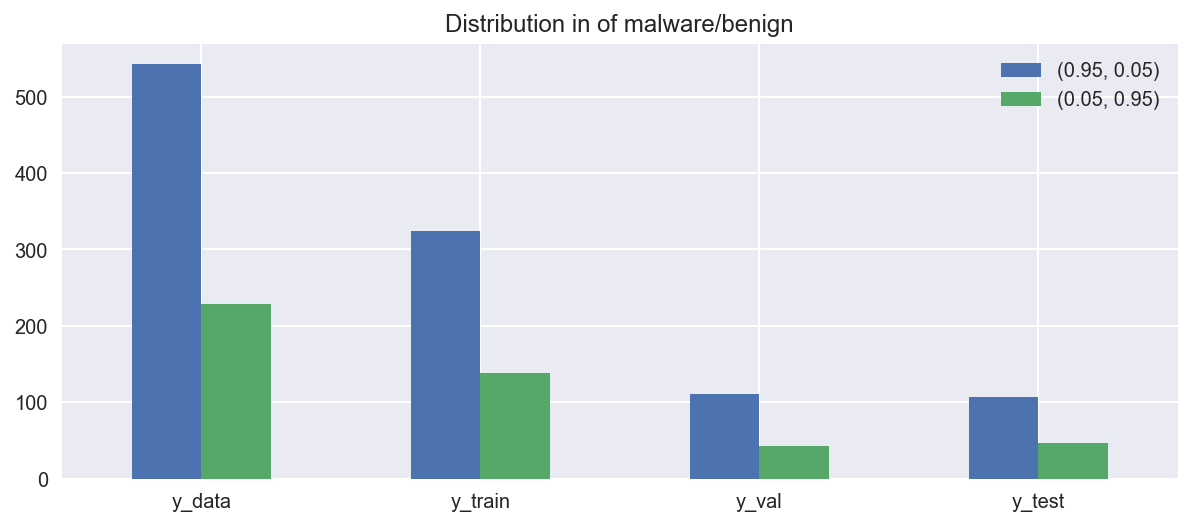

In [11]:
def frame(dataset, label):
    
    df = pd.DataFrame(dataset)
    columns = [() for _ in range(df.shape[1])]
    values = [None for _ in range(df.shape[1])]

    for n in df:
        for i, item in enumerate(df[n].value_counts().items()):
            columns[i] += (item[0],)
            values[i] = item[1]

    df = pd.DataFrame([values], index=[label], columns=columns)
    return df
    
df1 = frame(y_data, "y_data")
df2 = frame(y_train, "y_train")
df3 = frame(y_val, "y_val")
df4 = frame(y_test, "y_test")

df = pd.concat([df1, df2, df3, df4])
display(df)

hist = df.plot.bar(rot=0, figsize=(10, 4))
hist.set_title("Distribution in of malware/benign")
plt.show()

Thanks to this histogram, we are now sure that each set is representative of our global data.

## Build the model

<a style="float:right" href="https://en.wikipedia.org/wiki/Sensitivity_and_specificity#/media/File:Sensitivity_and_specificity.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg" width="250px">"Sensitivity and specificity", from Wikipedia</a>
As well as we do a classification, the purpose of the test dataset is to ensure that the classficiation is correct.  
The following is implemented under `Model.test(, X, Y)`

> **True positive** (TP): correctly identified   
    *We predicted "malware" and the true class is "malware"*  

> **False positive** (FP): incorrectly identified   
    *We predicted "not malware" and the true class is "not malware"*
        
> **True negative** (TN): correctly rejected    
    *We predicted "malware" and the true class is "not malware"*

> **False negative** (FN): incorrectly rejected     
    *We predicted "not malware" and the true class is "malware"*
    
The following measures can be calculated:
* **Accuracy**
* **Misclassification Error** (or Error Rate)
* **Receiver Operating Characteristic** (ROC)

More info on http://mlwiki.org/index.php/Evaluation_of_Binary_Classifiers#Accuracy_and_Error_Rate   

In [12]:
def is_malware(value : tuple):
    return True if value[0] > value[1] else False # ex: 0.91 > 0.12 means it is categorized as a malware

We register the model as a class in order to produce as many copies of this model as we want for soon generating each population of a our genetic algorithm.   
Here are most important methods:
* `__init__()` take all hyperparameters that will be dynamically modified by the genetic algorithm as arguments
* `build()` creates the Tensorflow graph given the model's hyperparameters
* `train_on_batch()` optimizes the internal weights of the model given the data and the `batch_size` (it can be 1)
* `validate_on_batch()` returns metrics of the current model tested on the given data and the batch size
* `fit()` calls `train_on_batch()` on the whole training set and validate its performance on the validation set each `epochs_between_reports`
* `test()` return metrics of the current model tested on the test set

In [13]:
class Model():

    def __init__(self, learning_rate=0.01, momentum=0.9, lr_decay=0.0, hidden_layers=1, hidden_size=1, activation="linear"):
        
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.lr_decay = lr_decay
        self.hidden_layers = hidden_layers
        self.hidden_size = hidden_size
        self.activation = activation
        
        self.train_losses = []
        self.validation_losses = []
        self.metrics = []
        self.times = []
        self.training_time = None

        self.status = "live" # other values: ["early_stopped", "gone_to_infinite"]
        self.aborted = False
        self.epochs_between_reports = 10
        self.desired_error = 0.001
        
        # Initialize session
        self.build(X_data.shape[1], y_data.shape[1])
        
    def build(self, input_shape, output_shape):
        
        tf.reset_default_graph()
        self.graph = tf.Graph()

        with self.graph.as_default():
            with tf.variable_scope("Core_layers"):

                # Pick between available activations
                activations = {"linear": None, "sigmoid": tf.nn.sigmoid, "tanh": tf.nn.tanh, "relu": tf.nn.relu}
                activation = activations[self.activation]
                
                # Input dense layer
                x = tf.placeholder(tf.float32, shape=(None, input_shape))
                y = tf.placeholder(tf.float32, shape=(None, output_shape))
                layers = [tf.layers.dense(inputs=x, units=self.hidden_size, activation=activation)]

                # Hidden layers
                for i in range(self.hidden_layers):
                    layers.append(tf.layers.dense(inputs=layers[-1], units=self.hidden_size, activation=activation))

                # Output dense layer
                output = tf.layers.dense(inputs=layers[-1], units=output_shape, activation=activation)

                # Loss function (MSE)
                loss = tf.losses.mean_squared_error(labels=y, predictions=output)

                # Optimize the loss minimization
                optimizer = tf.train.RMSPropOptimizer(self.learning_rate, momentum=self.momentum, decay=self.lr_decay)
                #optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
                train_op = optimizer.minimize(loss)

                # Add variables as params to be accessible in the whole object
                self.x = x
                self.y = y
                self.output = output
                self.loss = loss
                self.train_op = train_op
                self.sess = tf.Session()

                assert loss.graph is self.graph
            
    def train_on_batch(self, X, Y, batch_size=None, train=True):

        with self.graph.as_default():
            
            # Get variables from the building
            x, y = self.x, self.y
            loss, train_op = self.loss, self.train_op
            
            # Compute dataset windows corresponding to the batch size
            dataset_size = X.shape[0]
            batch_size = dataset_size if batch_size is None else batch_size
            windows = zip(range(0, dataset_size, batch_size), range(batch_size, dataset_size+1, batch_size))

            start_time = time.time()
            losses = []

            # Fetch by window of dataset[start:end]
            for start, end in windows:
                
                loss_t = self.sess.run([loss, train_op] if train is True else [loss], {x: X, y: Y})
                
                if not np.isfinite(loss_t[0]):
                    self.status = "gone_to_infinite"
                    self.aborted = True
                    break
                    
                losses.append(loss_t[0])

            # Return the mean loss and elapsed time for this epoch    
            return np.mean(losses), time.time() - start_time     
        
    def validate_on_batch(self, X, Y, batch_size=1):
        
        # Call train function but with train=False option
        return self.train_on_batch(X, Y, batch_size, train=False)
    
    def fit(self, X_train, Y_train, X_validation, Y_validation, X_test, Y_test, epochs, batch_size=None, early_stopping=True, verbose=False):

        if epochs % self.epochs_between_reports != 0:
            print("Warning: it is recommended to set a number of `epochs` divisible by the `epochs_between_reports`")
        
        with self.graph.as_default():

            train_losses = []
            validation_losses = []
            metrics = []
            times = []
            
            # Initialize weights and biais
            self.sess.run(tf.global_variables_initializer())

            # Fetch the dataset through epochs
            for i in range(1, epochs+1):

                # Train & save metrics
                loss, t = self.train_on_batch(X_train, Y_train, batch_size)
                train_losses.append(loss)
                times.append(t)
                
                if self.aborted:
                    break

                # Validate, test and fire early stopping if necessary
                if i % self.epochs_between_reports == 0:

                    # Validate
                    val_loss, t = self.validate_on_batch(X_validation, Y_validation, batch_size)
                    validation_losses.append(val_loss)
                    
                    # Test and save metrics
                    test_metrics = self.test(X_test, Y_test)
                    acc = test_metrics["accuracy"]
                    metrics.append(test_metrics)
                    
                    # Early Stopping
                    if early_stopping:
                        if len(validation_losses) > 2 and val_loss > validation_losses[-2]:
                            self.status = "early_stopped: val_loss gone up"
                            self.aborted = True
                        if val_loss < self.desired_error:
                            self.status = "early_stopped: desired error reached"
                            sefl.aborted = True
                        
                    if verbose is True:
                        print("epoch #{0:}\tloss: {1:.4f} / {2:.4f}\tacc: {3:.2f}".format(i, loss, val_loss, acc))
                    
            # Save the metrics
            self.train_losses = np.asarray(train_losses)
            self.validation_losses = np.asarray(validation_losses)
            self.metrics = np.asarray(metrics)
            self.times = np.asarray(times)
            self.training_time = np.sum(times)

            return self.train_losses, self.validation_losses, self.metrics, self.times
    
    def test(self, X, Y):
        
        with self.graph.as_default():
            classes = [(0.95, 0.05), (0.05, 0.95)]
        
            # Predict
            predicted = self.sess.run([self.output], {self.x: X})
            predicted = np.asarray(predicted[0])
            expected = Y

            # Establish the count of TP, TN, FP, FN
            TP, TN, FP, FN = 0, 0, 0, 0
            n_malwares = 0
            for pred, exp in zip(predicted, expected):
                n_malwares += 1 if is_malware(exp) else 0
                TP += 1 if is_malware(pred) and is_malware(exp) else 0
                TN += 1 if not is_malware(pred) and not is_malware(exp) else 0
                FP += 1 if is_malware(pred) and not is_malware(exp) else 0
                FN += 1 if not is_malware(pred) and is_malware(exp) else 0
                
            # Compute the rates
            accuracy = (TP + TN) / len(expected)
            error = 1 - accuracy
            TPR = TP / (TP + FN)
            FPR = FP / (FP + TN)
                
            return {
                "accuracy": accuracy,
                "error": error,
                "true_positive": TP,
                "true_negative": TN,
                "true_positive_rate": TPR,
                "false_positive": FP,
                "false_negative": FN,
                "false_positive_rate": FPR
            }
            
    def display_losses(self, figsize=(12, 4)):
        
        train, val = np.asarray(self.train_losses), np.asarray(self.validation_losses)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        x_axis = np.arange(len(val))/float(len(val)-1)*(len(train)-1)

        for ax in (ax1, ax2):
            data = [train, val] if ax == ax1 else [np.log(train), np.log(val)]
            ax.plot(data[0], label="train")
            ax.plot(x_axis, data[1], label="validation")
            ax.set_xlabel("epoch")
            ax.set_ylabel("loss")

        plt.suptitle("model losses after {}s".format(str(timedelta(seconds=self.training_time))), fontsize=16, y=1.10)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    def display_metrics(self, figsize=(8, 4)):
        
        acc = np.asarray([m["accuracy"] for m in self.metrics])
        
        # We also add the points (0, 0) and (1, 1)
        fpr = np.asarray([0, 1] + [m["false_positive_rate"] for m in self.metrics])
        tpr = np.asarray([0, 1] + [m["true_positive_rate"] for m in self.metrics])
        
        # Sort fpr
        p = fpr.argsort()
        fpr, tpr = fpr[p], tpr[p]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharey=True)
        ax1.plot(acc, label="accuracy", color="orange")
        ax1.set_xlabel("epoch")
        ax1.set_ylabel("accuracy")
        
        ax2.plot([0, 1], [0, 1], "--", color="gray")
        ax2.plot(fpr, tpr, "-r", zorder=1)
        ax2.scatter(fpr, tpr, marker=",", color=(0.8, 0, 0), s=10, zorder=2)
        ax2.set_xlabel("False Positive Rate")
        ax2.set_ylabel("True Positive Rate")
        
        plt.suptitle("metrics after {}s".format(str(timedelta(seconds=self.training_time))), fontsize=16, y=1.10)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    def free(self):
        with self.graph.as_default():
            self.sess.close()    
        
    def __delete__(self):
        self.free()

## The training part
At this point, we can create a model given the right parameters and test its performance.

In [14]:
# Found w/out the correction,
# the best for now
# params= {'hidden_layers': 0,
#         'hidden_size': 2,
#         'learning_rate': 0.013706071546456982,
#         'lr_decay': 0.011089306018502533,
#         'momentum': 0.5005674938587366}

# Found w/ correction of hidden_size in the first layer
# params= {'hidden_layers': 2,
#          'hidden_size': 6,
#          'learning_rate': 0.004958809888366004,
#          'lr_decay': 0.1078463266290153,
#          'momentum': 0.4032715476772463}
# params= {'hidden_layers': 2,
#          'hidden_size': 26,
#          'learning_rate': 0.0033873562586149166,
#          'lr_decay': 1.1711835015804154e-06,
#          'momentum': 0.25234057722690856}

# params = {'activation': 'sigmoid',
#          'hidden_layers': 1,
#          'hidden_size': 0,
#          'learning_rate': 0.17429191970420493,
#          'lr_decay': 0.09907799396487428,
#          'momentum': 0.1889544477838457}

params = {'activation': 'tanh',
 'hidden_layers': 3,
 'hidden_size': 9,
 'learning_rate': 0.0028803199879704213,
 'lr_decay': 0.06169868522111648,
 'momentum': 0.4612098539149855}

# params = {'learning_rate': 0.0004192211223496255,
#  'hidden_layers': 2,
#  'lr_decay': 0.00030996529008363977,
#  'hidden_size': 18,
#  'activation': 'tanh',
#  'momentum': 0.9207677937939145}


In [15]:
m1 = Model(**params)
m1.epochs_between_reports = 10

Train the model. For a more precise result, `batch_size=1` is better. For a quick result, `batch_size=None` will proceed the whole passed data as a batch.

In [16]:
train_losses, val_loss, metrics, t = m1.fit(X_train, y_train, X_val, y_val, X_test, y_test, epochs=1000, batch_size=None, early_stopping=False, verbose=True)

epoch #10	loss: 0.1626 / 0.1531	acc: 0.69
epoch #20	loss: 0.1188 / 0.1160	acc: 0.77
epoch #30	loss: 0.0895 / 0.0864	acc: 0.83
epoch #40	loss: 0.0766 / 0.0761	acc: 0.89
epoch #50	loss: 0.0690 / 0.0713	acc: 0.90
epoch #60	loss: 0.0636 / 0.0681	acc: 0.92
epoch #70	loss: 0.0593 / 0.0656	acc: 0.93
epoch #80	loss: 0.0558 / 0.0634	acc: 0.92
epoch #90	loss: 0.0527 / 0.0617	acc: 0.93
epoch #100	loss: 0.0501 / 0.0601	acc: 0.93
epoch #110	loss: 0.0478 / 0.0587	acc: 0.92
epoch #120	loss: 0.0458 / 0.0575	acc: 0.92
epoch #130	loss: 0.0441 / 0.0564	acc: 0.94
epoch #140	loss: 0.0425 / 0.0553	acc: 0.94
epoch #150	loss: 0.0410 / 0.0544	acc: 0.94
epoch #160	loss: 0.0397 / 0.0536	acc: 0.94
epoch #170	loss: 0.0385 / 0.0528	acc: 0.94
epoch #180	loss: 0.0373 / 0.0520	acc: 0.94
epoch #190	loss: 0.0362 / 0.0513	acc: 0.94
epoch #200	loss: 0.0352 / 0.0507	acc: 0.94
epoch #210	loss: 0.0343 / 0.0501	acc: 0.94
epoch #220	loss: 0.0334 / 0.0495	acc: 0.94
epoch #230	loss: 0.0326 / 0.0490	acc: 0.95
epoch #240	loss: 0.0

KeyboardInterrupt: 

In [ ]:
m1.display_losses()
m1.display_metrics()
m1.status

Get the accuracy from the test set:

In [ ]:
m1.test(X_test, y_test)

**/!\ Important:** do not forget to free the session, if not the memory will be huge in a while

In [ ]:
#del m1

## Genetic algorithm configuration
### Configure the hyperparameters that can be changed
Each parameters should be associated with a tuple describing the expected value like `(value_type, picking_function)`.

In [ ]:
hyperparameters = {
    "learning_rate": (float, lambda: 10 ** np.random.uniform(-4, 0)),
    "momentum": (float, lambda: np.random.uniform(0, 1)),
    "lr_decay": (float, lambda: 10 ** np.random.uniform(-6, 0)),
    "hidden_layers": (int, lambda: np.round(np.random.uniform(0, 5))),
    "hidden_size": (int, lambda: np.round(np.random.uniform(1, 25))),
    "activation": (str, lambda: np.random.choice(["linear", "sigmoid", "tanh"]))
}

### Configure the fitness function
The fitness function is the most important here, because it is what **determines the score of an individual** and thus a generation. The more precise it is, the more you have control over how your individuals are chosen and the speed of the convergence towards a good generation. However the components must stay sufficiently "free" and simple to reveal the real power of random solution.  

While the goal is to have a low fitness, we set **1000** as a default component evaluated value. The components of the fitness are the following:
* The last **accuracy** (emphasized)
* The last **train loss**
* The last **test loss**
* The **time** for an epoch

In [ ]:
def get_fitness_components(model) -> list:
    
    components = {
        "accuracy_emphasized": 1000, 
        "train_loss": 1000, 
        "validation_loss": 1000, 
        "mean_epoch_time": 1000
    }
    
    if len(model.train_losses) > 0 and len(model.metrics) > 0:
        components["accuracy_emphasized"] = np.sqrt(1-model.metrics[-1]["accuracy"]) * 10
        components["train_loss"] = model.train_losses[-1] 
        components["validation_loss"] = model.validation_losses[-1] 
        components["mean_epoch_time"] = np.mean(model.times) 
    
    return components

def calc_fitness(model):
    
    epochs = 300
    model.fit(X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, early_stopping=True)   
    fitness = 0
    for value in get_fitness_components(model).values(): # add up all components  
        fitness += value
    
    return fitness

The accuracy is the most important component, this is why we set it as emphasized. Also, the goal is to make a distinction between a 0.97 and 0.98 of accuracy. Here's how we do, using the **squared root**:

In [ ]:
accuracies = np.arange(0, 1, 0.001)
emphasized = np.sqrt(1-accuracies)*10

plt.plot(accuracies, 1-accuracies, label="linear 1-accuracy")
plt.plot(accuracies, emphasized, label="sqrt 1-accuracy x10")
plt.xlabel("Accuracies")
plt.ylabel("Fitness impact")
plt.legend()
plt.plot();

Then we can analyze how much each component of the fitness function was prominent. Taking **m1**, for example:

In [ ]:
m1_fitness = calc_fitness(m1)

In [ ]:
def analyze_fitness_components(model):
    components = get_fitness_components(model)
    for name in components.keys():
        components[name] = [components[name], m1_fitness, "{:.1%}".format(components[name] / m1_fitness)]
    
    return pd.DataFrame(components, index=["value", "fitness", "percentage"])

analyze_fitness_components(m1)

### Define the callback function
This is an optional function that will be called after each evolution, mostly for display-purpose:

In [ ]:
def callback():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    for p in ev.population:
        print(p)
        ax1.plot(p.obj.train_losses)
        ax2.plot(p.obj.validation_losses)
    ax1.set_title("Training losses")
    ax2.set_title("Validation losses")
    plt.show()

## Launch the genetic evolution 
Here's the command to reload the core module without reloading the whole notebook:

In [ ]:
import importlib
importlib.reload(genev)

import genev
from genev import Evolution, Individual

### Create the initial population

In [ ]:
ev = Evolution(10, structure=Model, dna_skeleton=skeleton)
ev.model(Model, skeleton, calc_fitness)
ev.create()

In [ ]:
ev.evaluate(display=True);

In [ ]:
callback();

### Evolve the population
Evolving the population can take some time. Here are some stats for training on **10% of the whole dataset**:   

For 300 epochs each and 10 individuals over 10 generations, it took like ~9min (`early_stopping=False`).   
For 300 epochs each and 15 individuals over 10 generations, it took like ~11min (`early_stopping=False`).   
For 300 epochs each and 15 individuals over 10 generations, it took like ~7min (`early_stopping=True`).   
For 300 epochs each and 15 individuals over 20 generations, it took like ~24min (`early_stopping=True`).   

> On a **dedicated server** (8 cores instead of 4):   
> For 300 epochs each and 15 individuals over 30 generations, it took like ~22min (`early_stopping=True`).   
> The result was not better.   

A few ideas in order to improve the time of the generations:
* Start with an estimation of a good generation


In [ ]:
ev.evolve(10, callback)
ev.evaluate(display=True)

### Display the best player in the game

In [ ]:
elite = ev.elite
elite.obj.display_losses()
elite.obj.display_metrics()
plt.show()

print(elite)
print("\t\ttrain_loss", elite.obj.train_losses[-1])
print("\t\tvalidation_loss", elite.obj.validation_losses[-1])

Parameters:

In [ ]:
elite.dna

Test the accuracy and get the metrics:

In [ ]:
elite.obj.test(X_test, y_test)

Fitness score composition:

In [ ]:
analyze_fitness_components(elite.obj)

### Analyze how parameters influences

In [ ]:
list(ev.skeleton_stats.keys())

The visual analysis will help us to understand which values were generated and how they are collerated to the success of the fitness score.


In [ ]:
ev.visual_analysis()

# Conclusion
Le genetic algorithm ne converge pas vers la bonne solution. Il reste à chaque fois dans un local optimum, que cela soit sur 10 ou 40 epochs. Il y a deux problèmes:
* Soit on permet à l'élite de muter, mais on peut le perdre. Finalement, le GA tourne en boucle sans jamais converger, changeant d'élite tout le temps.
* Soit on fixe l'élite. L'élite ne change pas, on reste bloqué. Finalement seul le tirage aléatoire du début influe. C'est à se demander si le crossover fonctionne vraiment ??

Ou alors il n'est juste pas possible de descendre plus bas.